<a href="https://colab.research.google.com/github/ChrizZhuang/marginalized_graph_kernel_protein/blob/main/Docking_0613.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up the environment

In [1]:
!nvidia-smi

Sun Jun 13 02:41:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#!pip install pymatgen==2020.12.31
!pip install pymatgen==2019.11.11
!pip install --pre graphdot
!pip install gdown

In [3]:
%matplotlib inline
import io
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages/')
import os
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import graphdot
from graphdot import Graph
from graphdot.graph.adjacency import AtomicAdjacency
from graphdot.graph.reorder import rcm
from graphdot.kernel.marginalized import MarginalizedGraphKernel # https://graphdot.readthedocs.io/en/latest/apidoc/graphdot.kernel.marginalized.html
from graphdot.kernel.marginalized.starting_probability import Uniform
from graphdot.model.gaussian_process import (
    GaussianProcessRegressor,
    LowRankApproximateGPR
)
from graphdot.kernel.fix import Normalization
import graphdot.microkernel as uX
import ase.io

# for getting all file names into a list under a directory 
from os import listdir
# for getting file names that match certain pattern
import glob
import time

/usr/local/lib/python3.7/dist-packages/graphdot/graph/__init__.py:24: UserWarning: Cannot import RDKit, `graph.from_rdkit()` will be unavailable.

  'Cannot import RDKit, `graph.from_rdkit()` will be unavailable.\n'


In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [5]:
#cd gdrive/MyDrive/Google\ Colab/Covid-Data
%cd gdrive/MyDrive/Covid-Data/

/content/gdrive/.shortcut-targets-by-id/1wtzMcocuK8kPsz8K0ktjCZPkv567W6M2/Covid-Data


In [6]:
!pwd

/content/gdrive/.shortcut-targets-by-id/1wtzMcocuK8kPsz8K0ktjCZPkv567W6M2/Covid-Data


In [7]:
!mkdir /content/pkls

## load the data

In [8]:
files  = ['uncharged_NSP15_6W01_A_3_H.Orderable_zinc_db_enaHLL.2col.csv.1.xz']
dataset = pd.read_pickle(files[0]) # length of each csv file is 100000

In [9]:
target = 'energy'
batch_size = 1000
batch_num_train = 0.8*len(dataset)//batch_size # batch number of training
num_test = 0.2*len(dataset)
train_data = dataset.iloc[:int(batch_num_train)*batch_size]
test_data = dataset.iloc[int(batch_num_train)*batch_size:len(dataset)]
#print(len(train_data))
#print(len(test_data))

In [10]:
gpr = GaussianProcessRegressor(
    # kernel is the covariance function of the gaussian process (GP)
    kernel=Normalization( # kernel equals to normalization -> normalizes a kernel using the cosine of angle formula, k_normalized(x,y) = k(x,y)/sqrt(k(x,x)*k(y,y))
        # graphdot.kernel.fix.Normalization(kernel), set kernel as marginalized graph kernel, which is used to calculate the similarity between 2 graphs
        # implement the random walk-based graph similarity kernel as Kashima, H., Tsuda, K., & Inokuchi, A. (2003). Marginalized kernels between labeled graphs. ICML
        MarginalizedGraphKernel( 
            # node_kernel - A kernelet that computes the similarity between individual nodes
            # uX - graphdot.microkernel - microkernels are positive-semidefinite functions between individual nodes and edges of graphs
            node_kernel=uX.Additive( # addition of kernal matrices: sum of k_a(X_a, Y_a) cross for a in features
                # uX.Constant - a kernel that returns a constant value, always mutlipled with other microkernels as an adjustable weight
                #   c, the first input arg. as 0.5, (0.01, 10) the lower and upper bounds of c that is allowed to vary during hyperpara. optimizartion
                # uX.KroneckerDelta - a kronecker delta returns 1 when two features are equal and return h (the first input arg here, which is 0.5 in this case) otherwise
                #   (0.1, 0.9) the lower and upper bounds that h is allowed to vary during hyperpara. optimization
                aromatic=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)), # the 2nd element of graphdot.graph.Graph.nodes
                atomic_number=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)), # the 3rd element of graphdot.graph.Graph.nodes
                # uX.SquareExponential - Equ. 26 in the paper
                # input arg. length_sacle is a float32, set as 1 in this case, which correspond to approx. 1 of the kernal value. 
                # This is used to determins how quicklys should the kernel decay to zero.
                charge=uX.Constant(0.5, (0.01, 10.0)) * uX.SquareExponential(1.0), # the 4th element of graphdot.graph.Graph.nodes
                chiral=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)), # the 5th element of graphdot.graph.Graph.nodes
                hcount=uX.Constant(0.5, (0.01, 10.0)) * uX.SquareExponential(1.0), # the 6th element of graphdot.graph.Graph.nodes
                hybridization=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)), # the 7th element of graphdot.graph.Graph.nodes
                # uX.Convolution - a convolutional microkernel which averages evaluations of a base microkernel between pairs pf elememts of two variable-length feature sequences
                # uX.KroneckerDelta as the base kernel
                ring_list=uX.Constant(0.5, (0.01, 100.0)) * uX.Convolution(uX.KroneckerDelta(0.5,(0.1, 0.9))) # the 8th element of graphdot.graph.Graph.nodes
            ).normalized,
            # edge_kernel - A kernelet that computes the similarity between individual edge
            edge_kernel=uX.Additive(
                aromatic=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)), # the 3rd element of graphdot.graph.Graph.nodes
                conjugated=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)), # the 4th element of graphdot.graph.Graph.nodes
                order=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)), # the 5th element of graphdot.graph.Graph.nodes
                ring_stereo=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)), # the 6th element of graphdot.graph.Graph.nodes
                stereo=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)) # the 7th element of graphdot.graph.Graph.nodes
            ).normalized,
            p=Uniform(1.0, p_bounds='fixed'), # the strating probability of the random walk on each node
            q=0.05 # the probability for the random walk to stop during each step
        )
    ),
    alpha=1e-4, # value added to the diagonal of the kernel matrix during fitting
    optimizer=True, # default optimizer of L-BFGS-B based on scipy.optimize.minimize
    normalize_y=True, # normalize the y values so taht the means and variance is 0 and 1, repsectively. Will be reversed when predicions are returned
    regularization='+', # alpha (1e-4 in this case) is added to the diagonals of the kernal matrix
)

In [11]:
def find_repeat_batch():
  lower_batch = 0
  lower_repeat = 0
  for f in listdir('/content/pkls'):
    f = f.split('_')
    f[3] = f[3].split('.')

    if int(f[1]) > lower_batch:
        lower_batch = f[1]
    if int(f[3][0]) > lower_repeat:
        lower_repeat = f[3][0]

  return lower_batch, lower_repeat


def train_pipeline_batch(model, train_dataset, test_dataset, target, repeats, batch_num_train, batch_size, verbose = True, print_batch = True, print_repeat = True):

  start_time = time.time()
  lower_batch, lower_repeat = find_repeat_batch()
  assert(lower_batch <= int(batch_num_train)-1)
  assert(lower_repeat <= repeats)

  for repeat in range(lower_repeat, repeats):
    for batch in range(lower_batch int(batch_num_train)-1):
      batch_dataset = dataset.iloc[batch*batch_size:(batch+1)*batch_size] # divide the training data into different batches
      np.random.seed(0)
      if batch == 0 and repeat == 0:
        model.fit(batch_dataset.graphs, batch_dataset[target], repeat=1, verbose=verbose)
        model.save(path="/content/pkls", filename='batch_0_repeat_0.pkl', overwrite=True)
      elif batch == 0 and repeat !=0:
        filename_load = 'batch_0_repeat_'+str(repeat-1)+'.pkl'
        filename_save = 'batch_0_repeat_'+str(repeat)+'.pkl'
        model.load(path="/content/pkls", filename=filename_load)
        model.fit(batch_dataset.graphs, batch_dataset[target], repeat=1, verbose=verbose)
        model.save(path="/content/pkls", filename=filename_save, overwrite=True)
      else:
        filename_load = 'batch_'+str(batch-1)+'_repeat_'+str(repeat)+'.pkl'
        filename_save = 'batch_'+str(batch)+'_repeat_'+str(repeat)+'.pkl'
        model.load(path="/content/pkls", filename=filename_load)
        model.fit(batch_dataset.graphs, batch_dataset[target], repeat=1, verbose=verbose)
        model.save(path="/content/pkls", filename=filename_save, overwrite=True)
      
      if print_batch:
        mu = gpr.predict(batch_dataset.graphs)
        print('   Training set of repeat '+str(repeat)+' and batch '+str(batch))
        print('   MAE '+str(repeat)+' and batch '+str(batch)+' '+str(np.mean(np.abs(batch_dataset[target] - mu))))
        print('   RMSE '+str(repeat)+' and batch '+str(batch)+' '+str(np.std(batch_dataset[target] - mu)))

    if print_repeat:
      mu = gpr.predict(train_dataset.graphs)
      print('Training set of repeat '+str(repeat))
      print('MAE '+str(repeat)+' '+str(np.mean(np.abs(train_dataset[target] - mu))))
      print('RMSE '+str(repeat)+' '+str(np.std(train_dataset[target] - mu)))

      mu = gpr.predict(test_dataset.graphs)
      print('Test set of repeat '+str(repeat))
      print('MAE '+str(repeat)+' '+str(np.mean(np.abs(test_dataset[target] - mu))))
      print('RMSE '+str(repeat)+' '+str(np.std(test_dataset[target] - mu)))
    
  
  end_time = time.time()
  print("the total time consumption is " + str(end_time - start_time) + ".")

In [12]:
train_pipeline_batch(gpr, train_data, test_data, target, repeats=2, batch_num_train=batch_num_train, batch_size=batch_size, print_batch = True, print_repeat = True)

|        logP|       dlogP|     y^T.K.y|     log|K| |     Cond(K)|  GPU time|  CPU time|
|------------|------------|------------|------------|------------|----------|----------|
|  2.7029e+06|  2.2705e+07|  2.7102e+06|       -7280|  8.8079e+06|        26|      0.26|
|   1.851e+06|  1.8813e+07|  1.8578e+06|     -6735.2|   8.231e+06|        21|      0.26|
|  1.2948e+06|  1.4695e+07|  1.3011e+06|     -6266.1|  7.4936e+06|        20|      0.24|
|  1.0214e+06|  1.1812e+07|  1.0274e+06|     -5976.6|  6.9034e+06|        19|      0.25|
|  8.4304e+05|  9.4765e+06|  8.4879e+05|     -5749.9|  6.3487e+06|        18|      0.24|
|  7.2855e+05|  7.8551e+06|  7.3413e+05|       -5577|  5.8872e+06|        17|      0.24|
|  6.6299e+05|   6.987e+06|  6.6846e+05|     -5466.2|  5.6111e+06|        17|      0.26|
|   6.461e+05|  6.6198e+06|  6.5155e+05|     -5451.9|  5.3943e+06|        16|      0.26|
|  6.2578e+05|  6.4801e+06|  6.3119e+05|     -5404.7|  5.3863e+06|        17|      0.25|
|  6.2068e+05|  6.444

KeyboardInterrupt: ignored

In [14]:
!zip -r /content/pkls.zip /content/pkls

  adding: content/pkls/ (stored 0%)
  adding: content/pkls/batch_34_repeat_0.pkl (deflated 35%)
  adding: content/pkls/batch_27_repeat_0.pkl (deflated 35%)
  adding: content/pkls/batch_3_repeat_0.pkl (deflated 35%)
  adding: content/pkls/batch_24_repeat_0.pkl (deflated 35%)
  adding: content/pkls/batch_16_repeat_0.pkl (deflated 35%)
  adding: content/pkls/batch_19_repeat_0.pkl (deflated 35%)
  adding: content/pkls/batch_14_repeat_0.pkl (deflated 35%)
  adding: content/pkls/batch_18_repeat_0.pkl (deflated 35%)
  adding: content/pkls/batch_29_repeat_0.pkl (deflated 35%)
  adding: content/pkls/batch_33_repeat_0.pkl (deflated 35%)
  adding: content/pkls/batch_17_repeat_0.pkl (deflated 35%)
  adding: content/pkls/batch_13_repeat_0.pkl (deflated 35%)
  adding: content/pkls/batch_12_repeat_0.pkl (deflated 35%)
  adding: content/pkls/batch_32_repeat_0.pkl (deflated 35%)
  adding: content/pkls/batch_23_repeat_0.pkl (deflated 35%)
  adding: content/pkls/batch_21_repeat_0.pkl (deflated 35%)
  add

In [15]:
from google.colab import files
files.download("/content/pkls.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
gpr.kernel.hyperparameters

starting_probability : Uniform
	p : 1.0
stopping_probability : 0.00010000000000000009
node_kernel : Composite
	aromatic : Multiply
		lhs : Constant
			c : 0.02343420535068002
		rhs : KroneckerDelta
			h : 0.18860200789175988
	atomic_number : Multiply
		lhs : Constant
			c : 5.400776905055444
		rhs : KroneckerDelta
			h : 0.10000000000000002
	charge : Multiply
		lhs : Constant
			c : 0.0145590563621646
		rhs : SquareExponential
			length_scale : 1.0
	chiral : Multiply
		lhs : Constant
			c : 0.05149063984443944
		rhs : KroneckerDelta
			h : 0.12853164901299938
	hcount : Multiply
		lhs : Constant
			c : 10.000000000000002
		rhs : SquareExponential
			length_scale : 0.07795674396128768
	hybridization : Multiply
		lhs : Constant
			c : 0.02783411902444354
		rhs : KroneckerDelta
			h : 0.17414808329497075
	ring_list : Multiply
		lhs : Constant
			c : 6.550981640628747
		rhs : Convolution
			base : KroneckerDelta
				h : 0.10000000000000002
edge_kernel : Composite
	aromatic : Multiply
		lhs 

In [ ]:
mu = gpr.predict(train.graphs)

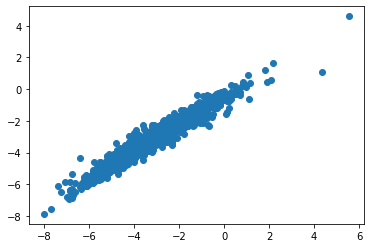

In [ ]:
plt.scatter(train[target], mu)
plt.show()

In [ ]:
print('Training set')
print('MAE:', np.mean(np.abs(train[target] - mu)))
print('RMSE:', np.std(train[target] - mu))

Training set
MAE: 0.2074369392067814
RMSE: 0.3195501910711287


In [ ]:
mu_test = gpr.predict(test.graphs)

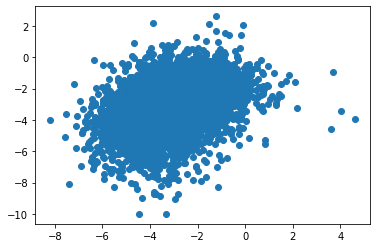

In [ ]:
plt.scatter(test[target], mu_test)
plt.show()

In [ ]:
print('Test set')
print('MAE:', np.mean(np.abs(test[target] - mu_test)))
print('RMSE:', np.std(test[target] - mu_test))

Test set
MAE: 1.2461703788060545
RMSE: 1.6040210737240486


Workon the kernel. Find a kernel that trains and predicts well.

In [ ]:
gpr2 = GaussianProcessRegressor(
    kernel=Normalization(
        MarginalizedGraphKernel(
            node_kernel=uX.Additive(
                aromatic=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                atomic_number=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)),
                charge=uX.Constant(0.5, (0.01, 10.0)) * uX.SquareExponential(1.0),
                chiral=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                hcount=uX.Constant(0.5, (0.01, 10.0)) * uX.SquareExponential(1.0),
                hybridization=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                ring_list=uX.Constant(0.5, (0.01, 100.0)) * uX.Convolution(uX.KroneckerDelta(0.5,(0.1, 0.9)))
            ).normalized,
            edge_kernel=uX.Additive(
                aromatic=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                conjugated=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                order=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)),
                ring_stereo=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)),
                stereo=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9))
            ).normalized,
            p=Uniform(1.0, p_bounds='fixed'),
            q=0.05
        )
    ),
    alpha=1e-2, #different from gpr in alpha where gpr's alpha is 1e-4
    optimizer=True,
    normalize_y=True,
    regularization='+',
)

In [ ]:
#gpr2.fit(train.graphs, train[target], repeat=3, verbose=True)
gpr2.fit(train.graphs, train[target], repeat=1, verbose=True)

|        logP|       dlogP|     y^T.K.y|     log|K| |     Cond(K)|  GPU time|  CPU time|
|------------|------------|------------|------------|------------|----------|----------|
|   1.667e+05|   1.928e+05|  1.7773e+05|      -11034|  2.2742e+05|   1.3e+02|       1.7|
|  1.5585e+05|  2.2171e+05|  1.6671e+05|      -10857|  2.2218e+05|   1.3e+02|       1.7|
|  1.3711e+05|  2.4873e+05|  1.4756e+05|      -10447|  2.0803e+05|   1.2e+02|       1.8|
|  1.3286e+05|  2.3627e+05|   1.432e+05|      -10338|  2.0336e+05|   1.1e+02|       1.7|
|  1.2977e+05|  2.2744e+05|  1.4002e+05|      -10249|  1.9714e+05|   1.1e+02|       1.7|
|  1.3006e+05|  2.1429e+05|  1.4032e+05|      -10258|  2.0119e+05|     1e+02|       1.7|
|  1.2923e+05|  2.2103e+05|  1.3946e+05|      -10238|  1.9906e+05|   1.1e+02|       1.7|
|  1.2888e+05|  2.2097e+05|  1.3911e+05|      -10228|  1.9865e+05|   1.1e+02|       1.7|
|  1.2843e+05|  2.2338e+05|  1.3864e+05|      -10211|  1.9582e+05|   1.1e+02|       1.7|
|  1.2837e+05|  2.224

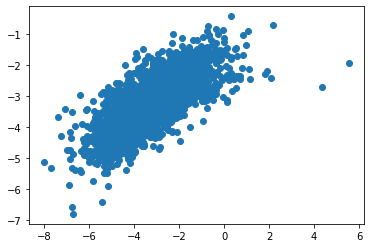

In [ ]:
mu = gpr2.predict(train.graphs)
plt.scatter(train[target], mu)
plt.show()

In [ ]:
print('Training set')
print('MAE:', np.mean(np.abs(train[target] - mu)))
print('RMSE:', np.std(train[target] - mu))

Training set
MAE: 0.7238389142657052
RMSE: 0.9634943206325994


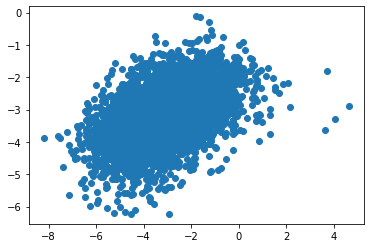

In [ ]:
mu_test = gpr2.predict(test.graphs)
plt.scatter(test[target], mu_test)
plt.show()

In [ ]:
print('Test set')
print('MAE:', np.mean(np.abs(test[target] - mu_test)))
print('RMSE:', np.std(test[target] - mu_test))

Test set
MAE: 0.9561539409612109
RMSE: 1.2284268143181998
